In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from river import compose
from river import linear_model
from river import metrics
from river import preprocessing
from river import optim
from river import neural_net


# Assuming df is your DataFrame and 'consumption' is your target variable
df = pd.read_csv('wheaterVersion.csv')

df.head()


,datetime,Customer,Generator Capacity,Postcode,Consumption Category,consumption,temperature_2m,precipitation,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,is_day,sunshine_duration
0,2010-07-01 00:00:00,201,1.75,2291,GG,0.000,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
1,2010-07-01 00:00:00,36,1.00,2137,GG,0.000,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
2,2010-07-01 00:00:00,36,1.00,2137,CL,2.209,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
3,2010-07-01 00:00:00,36,1.00,2137,GC,0.191,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0
4,2010-07-01 00:00:00,35,2.10,2284,GG,0.000,24.0,0.0,35.1,12.0,0.0,81.0,1.0,3600.0


In [37]:


# Convert 'datetime' column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Create a subset only for customer 36
customer_36 = df[df['Customer'] == 36].copy()
#only use GG consumption category
customer_36 = customer_36[customer_36['Consumption Category'] == 'GG'].copy()
#drop consumption category
customer_36 = customer_36.drop('Consumption Category', axis=1)
#drop customer
customer_36 = customer_36.drop('Customer', axis=1)
#drop generator capacity
customer_36 = customer_36.drop('Generator Capacity', axis=1)

#drop post code
customer_36 = customer_36.drop('Postcode', axis=1)



# Convert 'datetime' column to datetime format
customer_36['datetime'] = pd.to_datetime(customer_36['datetime'])

# Extract day of the week and month from 'datetime'
customer_36['day_of_week'] = customer_36['datetime'].dt.dayofweek
customer_36['month'] = customer_36['datetime'].dt.month
customer_36['hour'] = customer_36['datetime'].dt.hour
customer_36['day'] = customer_36['datetime'].dt.day

DateList = customer_36['datetime'].tolist()
DateList = DateList[168*4:]

# Drop original 'datetime' column


print(len(customer_36))

#split the 168 hours into its own dataframe for testing on the last week
test = customer_36.tail(168*4)
customer_36 = customer_36.head(-168*4)

DateListTest = test['datetime'].tolist()

customer_36 = customer_36.drop('datetime', axis=1)
test = test.drop('datetime', axis=1)

print(len(customer_36))


26304
25632


In [41]:
import numpy as np
# Create a new DataFrame with all the columns except 'consumption'
X = customer_36.drop('consumption', axis=1)
y = customer_36['consumption']

# Create a pipeline with a standard scaler and a neural network model


#neural_net.activations.ReLU
#neural_net.activations.Identity
#neural_net.activations.Sigmoid

model = compose.Pipeline(
    preprocessing.StandardScaler(),
    neural_net.MLPRegressor(
        #3.19 = MAE: 0.027252 Modified MAE: 0.027252017222437194
        
        #Best neuron numbers: (5, 27, 13)
        #Best neuron numbers: (5, 27, 13), best MAE: 0.015826061440739662
        
        #best neuron numbers: (5, 2, 9,5), best MAE: 0.01608
        
        hidden_dims=(5,27,13),
        activations=(neural_net.activations.ReLU, 
                     
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,
                     neural_net.activations.ReLU,

                                         
                     neural_net.activations.Identity),
        optimizer=optim.SGD(0.08),
        seed=42
    )
)

# Initialize a metric and lists to store actual values and predictions
metric = metrics.MAE()
y_true = []
y_pred_list = []

# Initialize a counter for the number of instances seen
n_instances = 0

# Iterate over the DataFrame, updating the model and the metric
for xi, yi in zip(X.itertuples(index=False), y):
    y_pred = model.predict_one(xi._asdict())  # make a prediction
    model.learn_one(xi._asdict(), yi)  # update the model

    # Only start updating the metric and storing predictions after a year's worth of values

    metric.update(yi, y_pred)  # update the metric

    # Store actual values and predictions
    y_true.append(yi)
    y_pred_list.append(y_pred)

    # Increment the counter
    n_instances += 1
    
print(f'MAE: {metric.get()}')


MAE: 0.030474401949723024


MAE: 0.030474
Modified MAE: 0.030474401949723024
25632
25632


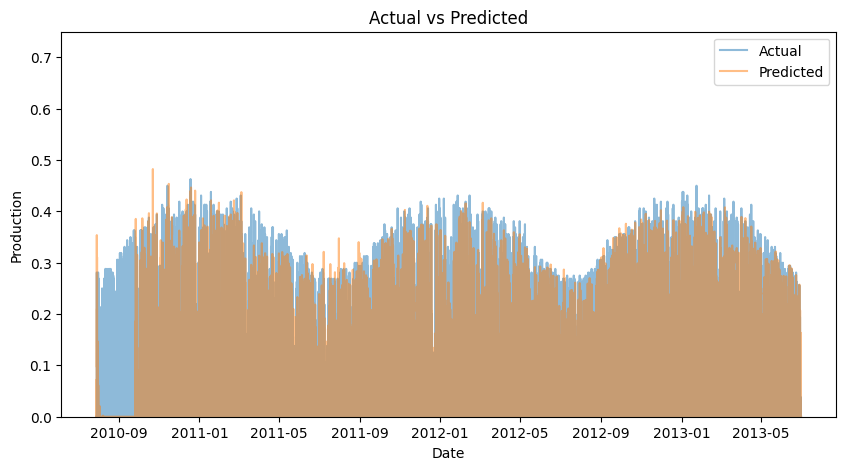

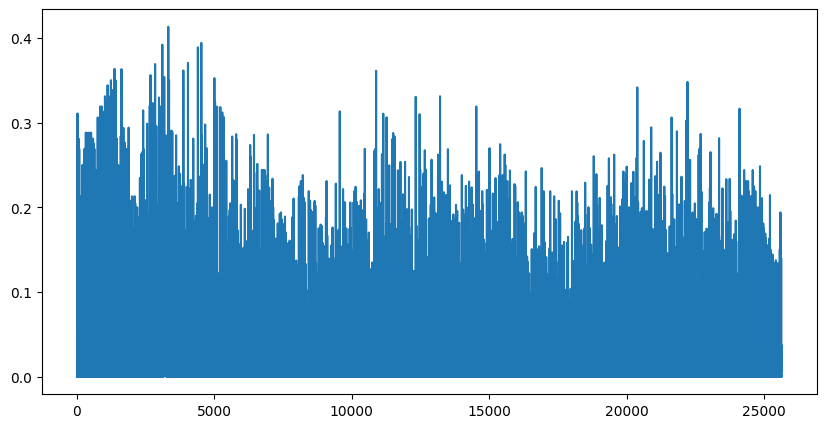

In [39]:
print(metric)
std_dev = np.std(y_pred_list)
modified_mae = metric.get() + max(0, 0.1 - std_dev)
print('Modified MAE:', modified_mae)
# Plot actual values and predictions
plt.figure(figsize=(10, 5))
#set y axis limit
plt.ylim(0, 0.75)
#set x axis limit


#get a list of dates out of the training data


print(len(DateList))
print(len(y_true))

plt.plot(DateList,y_true, alpha=0.5,label='Actual')
plt.plot(DateList,y_pred_list,  alpha=0.5,label='Predicted')
#add tittle
plt.title('Actual vs Predicted')

plt.legend()
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()


#error graph over time
plt.figure(figsize=(10, 5))
plt.plot([abs(y_true[i] - y_pred_list[i]) for i in range(len(y_true))])
plt.show()



Pandas(temperature_2m=19.75, precipitation=0.5, cloud_cover=100.0, cloud_cover_low=100.0, cloud_cover_mid=98.0, cloud_cover_high=97.0, is_day=1.0, sunshine_duration=0.0, day_of_week=0, month=6, hour=0, day=3)
Pandas(temperature_2m=19.8, precipitation=0.4, cloud_cover=100.0, cloud_cover_low=100.0, cloud_cover_mid=97.0, cloud_cover_high=97.0, is_day=1.0, sunshine_duration=3600.0, day_of_week=0, month=6, hour=1, day=3)
Pandas(temperature_2m=19.85, precipitation=0.4, cloud_cover=100.0, cloud_cover_low=100.0, cloud_cover_mid=92.0, cloud_cover_high=80.0, is_day=1.0, sunshine_duration=49.047775, day_of_week=0, month=6, hour=2, day=3)
Pandas(temperature_2m=19.8, precipitation=0.5, cloud_cover=100.0, cloud_cover_low=100.0, cloud_cover_mid=94.0, cloud_cover_high=3.0, is_day=1.0, sunshine_duration=0.0, day_of_week=0, month=6, hour=3, day=3)
Pandas(temperature_2m=19.7, precipitation=0.1, cloud_cover=100.0, cloud_cover_low=100.0, cloud_cover_mid=95.0, cloud_cover_high=16.0, is_day=1.0, sunshine_dur

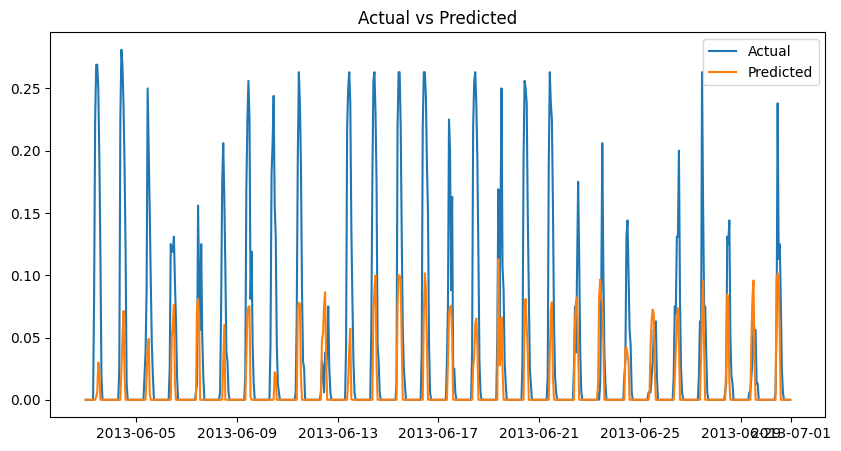

AttributeError: 'Series' object has no attribute '_asdict'

In [43]:
#set test index to 0
test = test.reset_index(drop=True)

# Test the model on the last week of data
y_true_test = test['consumption']
y_pred_test = []
for xi in test.drop('consumption', axis=1).itertuples(index=False):
    print(xi)
    y_pred_test.append(model.predict_one(xi._asdict()))
    
# Calculate the MAE on the test set
metric_test = metrics.MAE()
for yi, y_pred in zip(y_true_test, y_pred_test):
    metric_test.update(yi, y_pred)
print('Test MAE:', metric_test)

# Plot actual values and predictions for the test set
plt.figure(figsize=(10, 5))
plt.plot(DateListTest,y_true_test, label='Actual')
plt.plot(DateListTest,y_pred_test, label='Predicted')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()





# Set test index to 0
test = test.reset_index(drop=True)

# Initialize the lists for true values and predictions
y_true_test = []
y_pred_test = []

# Iterate over the test data
for i in range(len(test) - 7):  # Exclude the last 7 days
    # Get the current data point
    xi = test.drop('consumption', axis=1).iloc[i].to_dict()
    
    # Predict the consumption for the current data point
    y_pred = model.predict_one(xi)
    y_pred_test.append(y_pred)
    
    # Get the true consumption 7 days after the current data point
    yi = test['consumption'].iloc[i + 7]
    y_true_test.append(yi)
    
    # Update the model with the true consumption 7 days after the prediction
    model.learn_one(xi, yi)

# Calculate the MAE on the test set
metric_test = metrics.MAE()
for yi, y_pred in zip(y_true_test, y_pred_test):
    metric_test.update(yi, y_pred)
print('Test MAE:', metric_test)

# Plot actual values and predictions for the test set
plt.figure(figsize=(10, 5))
plt.plot(DateListTest[:-7], y_true_test, label='Actual')  # Exclude the last 7 days from the dates
plt.plot(DateListTest[:-7], y_pred_test, label='Predicted')  # Exclude the last 7 days from the dates
plt.title('Actual vs Predicted')
plt.legend()
plt.show()




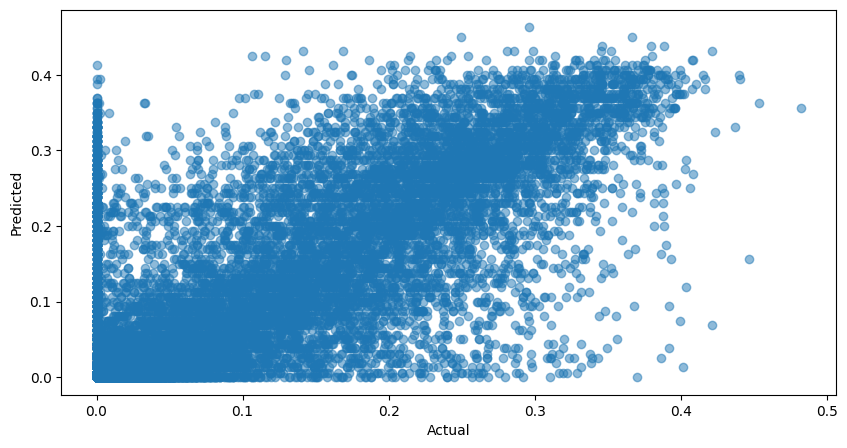

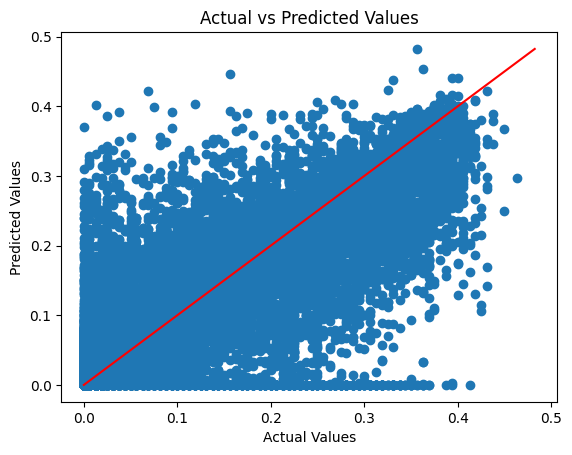

In [31]:
#scatter plot 
plt.figure(figsize=(10, 5))
plt.scatter(y_pred_list, y_true, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()




plt.scatter(y_true, y_pred_list)

# Create a 45 degree line
max_value = max(max(y_true), max(y_pred_list))
plt.plot([0, max_value], [0, max_value], color='red')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

plt.show()





In [32]:
# Define a list of neuron numbers for the grid search
neuron_numbers = [(i, j) for i in range(1, 20) for j in range(1, 20)]

# Initialize a dictionary to store the metrics for each neuron number
metrics_dict = {}

# Perform grid search
for nn in neuron_numbers:
    # Create a pipeline with a standard scaler and a neural network model
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        neural_net.MLPRegressor(
            hidden_dims=nn,
            activations=(neural_net.activations.ReLU,
                          
                         neural_net.activations.ReLU, 
                         neural_net.activations.ReLU, 
                         
                         neural_net.activations.Identity),
            optimizer=optim.SGD(0.01),
            seed=42
        )
    )

    # Initialize a metric and lists to store actual values and predictions
    metric = metrics.MAE()
    y_true = []
    y_pred_list = []

    # Iterate over the DataFrame, updating the model and the metric
    for xi, yi in zip(X.itertuples(index=False), y):
        y_pred = model.predict_one(xi._asdict())  # make a prediction
        model.learn_one(xi._asdict(), yi)  # update the model
        metric.update(yi, y_pred)  # update the metric

        # Store actual values and predictions
        y_true.append(yi)
        y_pred_list.append(y_pred)

    # Store the metric for this neuron number
    metrics_dict[nn] = metric

# Print the metrics for each neuron number
for nn, metric in metrics_dict.items():
    print(f"Neuron numbers: {nn}, MAE: {metric}")
    
# Find the neuron numbers that resulted in the lowest MAE
best_nn = min(metrics_dict, key=metrics_dict.get)
print(f"Best neuron numbers: {best_nn}")


KeyboardInterrupt: 

In [ ]:
import concurrent.futures

# Define a function to train a model and return the MAE
def train_model(nn):
    model = compose.Pipeline(
        preprocessing.StandardScaler(),
        neural_net.MLPRegressor(
            hidden_dims=nn,
            activations=(neural_net.activations.ReLU, 
                         neural_net.activations.ReLU, 
                         neural_net.activations.Identity),
            optimizer=optim.SGD(0.01),
            seed=42
        )
    )

    metric = metrics.MAE()

    for xi, yi in zip(X.itertuples(index=False), y):
        y_pred = model.predict_one(xi._asdict())
        model.learn_one(xi._asdict(), yi)
        metric.update(yi, y_pred)

    return nn, metric
neuron_numbers = [(i, j) for i in range(1, 20) for j in range(1, 20)]

# Perform grid search using a process pool
with concurrent.futures.ProcessPoolExecutor() as executor:
    metrics_dict = dict(executor.map(train_model, neuron_numbers))

# Print the metrics for each neuron number
for nn, metric in metrics_dict.items():
    print(f"Neuron numbers: {nn}, MAE: {metric}")

# Find the neuron numbers that resulted in the lowest MAE
best_nn = min(metrics_dict, key=metrics_dict.get)
print(f"Best neuron numbers: {best_nn}")

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
for nn, metric in metrics_dict.items():
    print(f"Neuron numbers: {nn}, MAE: {metric}")

Neuron numbers: (1, 1), MAE: MAE: 0.068823
Neuron numbers: (1, 2), MAE: MAE: 0.068823
Neuron numbers: (1, 3), MAE: MAE: 0.068823
Neuron numbers: (1, 4), MAE: MAE: 0.068823
Neuron numbers: (1, 5), MAE: MAE: 0.082139
Neuron numbers: (1, 6), MAE: MAE: 0.068823
Neuron numbers: (1, 7), MAE: MAE: 0.068823
Neuron numbers: (1, 8), MAE: MAE: 0.076402
Neuron numbers: (1, 9), MAE: MAE: 0.068823
Neuron numbers: (1, 10), MAE: MAE: 0.068823
Neuron numbers: (1, 11), MAE: MAE: 0.069113
Neuron numbers: (1, 12), MAE: MAE: 0.068823
Neuron numbers: (1, 13), MAE: MAE: 0.068823
Neuron numbers: (1, 14), MAE: MAE: 0.069004
Neuron numbers: (1, 15), MAE: MAE: 0.068823
Neuron numbers: (1, 16), MAE: MAE: 0.068823
Neuron numbers: (1, 17), MAE: MAE: 0.068823
Neuron numbers: (1, 18), MAE: MAE: 0.068823
Neuron numbers: (1, 19), MAE: MAE: 0.068855
Neuron numbers: (1, 20), MAE: MAE: 0.052284
Neuron numbers: (1, 21), MAE: MAE: 0.068823
Neuron numbers: (1, 22), MAE: MAE: 0.068837
Neuron numbers: (1, 23), MAE: MAE: 0.0688

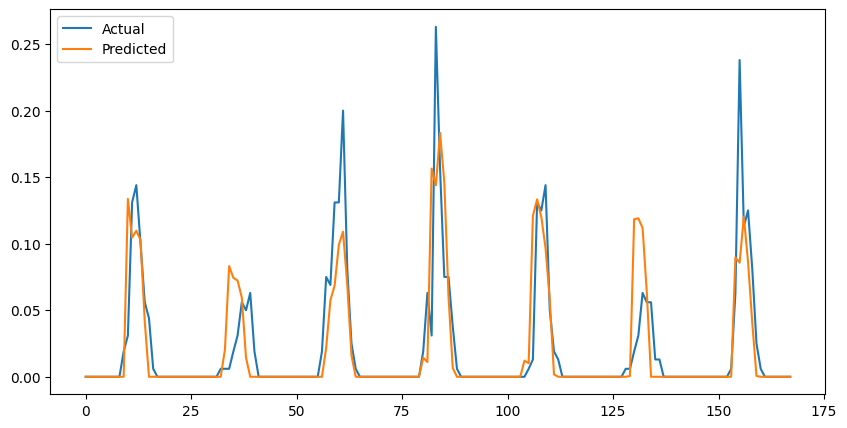

In [ ]:
#plot the last week of data with actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_true[-168:], label='Actual')
plt.plot(y_pred_list[-168:], label='Predicted')
plt.legend()
plt.show()
